## This demo provides an implementation of sufrface coil intensity correction (SCC) for data collected on a Siemens scanner.
### Make sure that you have cloned the [SCC repository](https://github.com/OSU-MR/SCC) from GitHub and are executing brightness_correction_demo_ipynb from the SCC folder.
### Before you run the demo, make sure that the your environment is setup properly. To do that, execute these commands in the terminal. Then, make sure that the SCC environment is selected for this code to run.
* conda create --name SCC python=3.8
* conda activate SCC
* conda install jupyterlab
* conda install ipykernel
* python -m ipykernel install --user --name=SCIC


### The following cell will install [Twix Tools](https://github.com/OSU-MR/Python_read_Siemens_rawdata) and then replace twix_map.py with the one modified by Dr. Chong Chen (GitHub ID: MRIOSU)
* Twix Tools are needed to read the raw datafile from Siemens scanners

In [1]:
from helper_functions.download_data import download_file_from_figshare, install_twixtools 
install_twixtools()

please read README.md to run the code.
The code is still under development.
plesae contact me for adding more data shape support.
lei.337@osu.edu
Extracting the zip file...
Replacing twix_map.py...
Sufficient numpy version is already installed.
Installing twixtools...
Processing /home/Xuan/LGE_project/git_rewriten/SCC-main/twixtools-master
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for twixtools: filename=twixtools-1.0-py3-none-any.whl size=51387 sha256=755b70471d5178a4c163c12d10db978ea0d4e6af1f243368d30265e3abe5ab4b
  Stored in directory: /home/Xuan/.cache/pip/wheels/46/c2/a6/ec2999e775cba741154964bd75d634d00615e831d9687ea96b
Successfully built twixtools
  Attempting uninstall: twixtools
    Found existing installation: twixtools 1.0
    Uninstalling twixtools-1.0:
      Successfully uninstalled twixtools-1.0
Removing the zip file and the extracted directory...
Installing numpy==1.23.4...
Installing sigpy==0.1.

<!-- # 2. Organize the folders of your datasets
# **The sturcture of your dataset folders should be like this:**
<style>
code {
    font-size: 15px;
}
</style>
```markdown


base_dir-----input_folder-----folder name of your datasets_1
          |                |--folder name of your datasets_2
          |                |              ...
          |		        --folder name of your datasets_n
          |
          |
          | (folders below will be automatically created)
          ---output_folder------correction map folder of your datasets_1    
			     |--correction map folder of your datasets_2         
			     |                ...                 
                 ---correction map folder of your datasets_n

``` -->

### This cell will automatically download a raw data file that we have uploaded on [figshare](figshare.com). Be patient, downloading the file may take a few minutes.
* The downloaded file is saved in SCC/data/rawdata/demo folder while the results are saved on SCC/data/results/demo
* The link 'url_2CH' has a series of images from a single slice (620 MB). The link 'url_SAX' has series of images from multiple slices (5.2 GB)

In [2]:
import os
from helper_functions.download_data import download_file_from_figshare
# Path: ./data
#create base directory
os.makedirs('./data', exist_ok=True)

#create subdirectories
os.makedirs('./data/rawdata', exist_ok=True)
os.makedirs('./data/rawdata/demo', exist_ok=True)

#download the data
# saving_path = './data/rawdata/'
saving_path = './data/rawdata/demo/'
url_2CH = "https://figshare.com/ndownloader/files/41881158" # image collected in two-chambers view
# url_SAX = "https://figshare.com/ndownloader/files/41915115" # image stack collected in short-axis view

print("Demo datasets are being downloaded, please wait......")
download_file_from_figshare(saving_path, url_2CH) # May take a couple of minutes to download
# download_file_from_figshare(saving_path,url_SAX) # May take tens of minutes to download


# if we are using free version of Google Colab then you may not want to download the multi-slice short-axis (SAX) data because of it's large size
# if 'google.colab' not in str(get_ipython()):
    # download_file_from_figshare(saving_path,url_SAX) # May take tens of minutes to download

base_dir = "./data"
input_folder = "rawdata"
input_subfolders = ['demo'] #set this to None, if you want to go through all the subfolders inside input_folder
output_folder = "results"

Demo datasets are being downloaded, please wait......
File saved as meas_MID00091_FID54254_DE_TRUFI_2CH_MOCO_30avg.dat


<!-- # 3. Import the functions and define the folders -->

### The data that we have provided is fully sampled. So, no reconstruction is required other than coil-combiniging. If your data is undersampled, you could call your own reconstruction routine from the function 'CustomProcedure'.

In [5]:
# from helper_functions.brightness_correction import , getting_and_saving_correction_map, create_and_start_threadings, 
from helper_functions.brightness_correction import target_path_generator, displaying_results, rawdata_reader, correction_map_generator, auto_image_rotation, middle_slice, save_sense_recon_results
from helper_functions.recon import sense_reconstruction, remove_edges, rotate_image, pad_ref
from helper_functions.preprocess import ifftnd, rms_comb,remove_RO_oversamling

import numpy as np

### Apply SCC to correct intensity

In [6]:
#generate target paths
path_input, path_output,  = target_path_generator(base_dir, input_folder, output_folder, input_subfolders)

In [7]:
auto_rotation = 'LGE' # 'Dicom' or 'LGE'
apply_correction_during_sense_recon = False # True or False

for i, data_path_filename in enumerate(path_input):
    
    twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, data_ref, dim_info_ref, num_sli = rawdata_reader(data_path_filename)

    img_correction_maps, sensitivity_correction_maps, low_resolution_surface_coil_imgs, img_quats = correction_map_generator(twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, num_sli , auto_rotation = auto_rotation)


    #define sense recon results
    sense_recon_results = np.zeros((num_sli,data.shape[dim_info_data.index('Lin')],data.shape[dim_info_data.index('Col')]//2),dtype=np.complex64)

    for n in range(num_sli):

        #preprocessing for the sense reconstruction
        #only do recon for the middle slice
        data,dim_info_org = middle_slice(data,data_dimensions = dim_info_data, dims_to_keep = ['Sli', 'Lin', 'Cha', 'Col'])

        ksp,ref_padded = pad_ref(data,data_ref,n,dim_info_ref = dim_info_ref,dim_info_org=dim_info_data)
        ksp = remove_RO_oversamling(ksp,axis_RO=2)
        ref_padded = remove_RO_oversamling(ref_padded,axis_RO=2)

        if apply_correction_during_sense_recon:
            #if we want to apply the correction during the sense reconstruction
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded,sensitivity_correction_maps[n,...])
        else:
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded)

        sense_recon_results[n,...] = sense_reconstructed_img


    #we are rotating the images here
    sense_recon_results, img_correction_maps, sensitivity_correction_maps = auto_image_rotation(sense_recon_results, img_quats, 
                                                                            auto_rotation = auto_rotation, 
                                                                            img_correction_maps = img_correction_maps, 
                                                                            sensitivity_correction_maps = sensitivity_correction_maps,
                                                                            filename = data_path_filename)
    
    #save the results
    save_sense_recon_results(path_output[i],sense_recon_results, img_correction_maps, sensitivity_correction_maps, img_quats, apply_correction_during_sense_recon)
        
            


Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 736MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.35GB/s]



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

# 6. For displaying the result, use **displaying_results()** function like this:

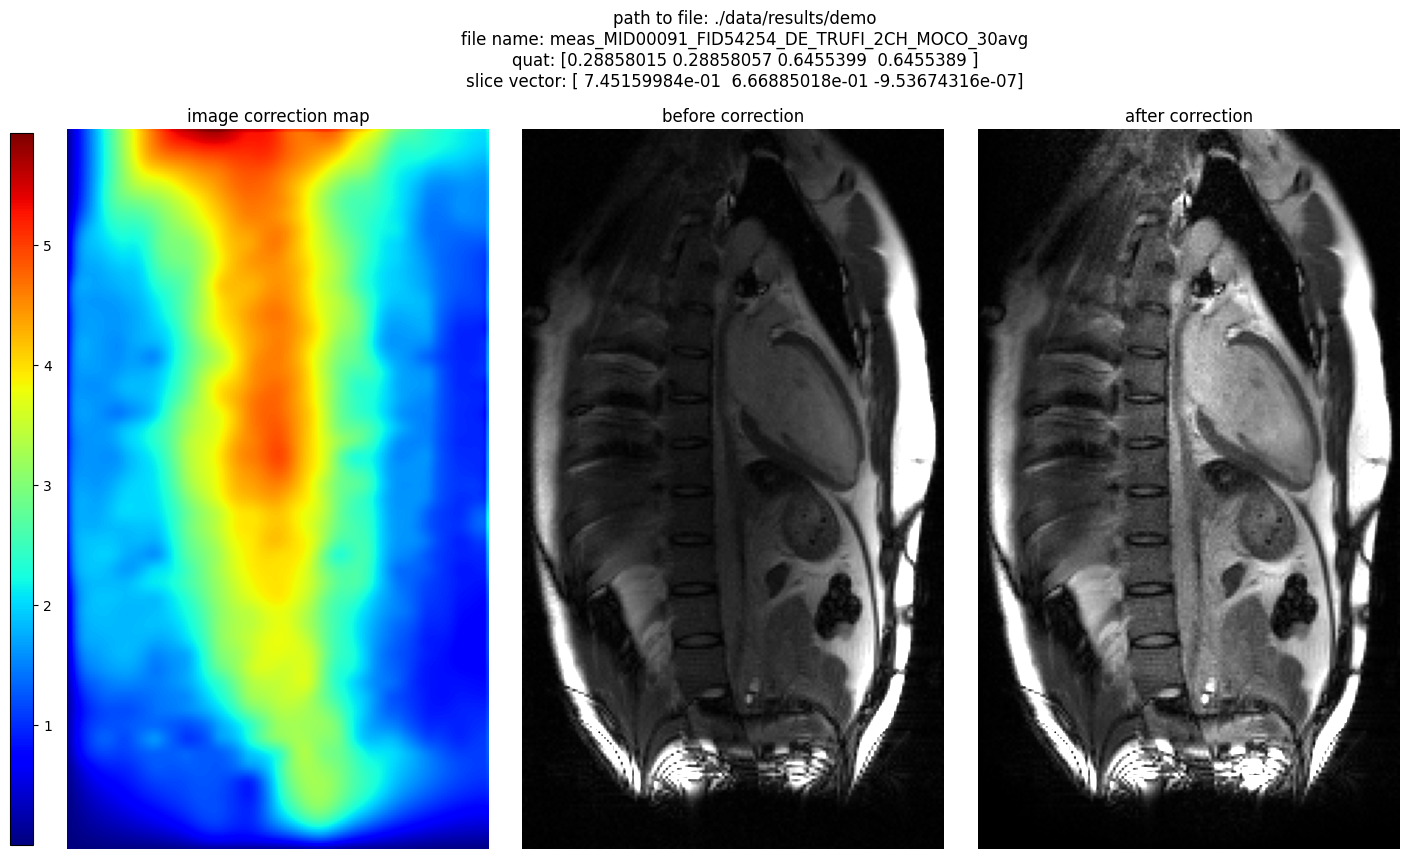

In [8]:
sli_idx = 0 #changing this number will show different slices
input_subfolders = ['demo'] #set this to None, if you want to go through all the subfolders inside input_folder
output_folder = "results"
displaying_results(base_dir=base_dir, input_folder=input_folder,
                   output_folder=output_folder, folder_names=input_subfolders, sli_idx=sli_idx,
                   fig_h=9, show_both=False) #set debug = True to display more information


# 7. Set **apply_correction_during_sense_recon = True** to apply the correction during the sense reconstruction

In [9]:
auto_rotation = 'LGE' # 'Dicom' or 'LGE'
apply_correction_during_sense_recon = True # True or False

for i, data_path_filename in enumerate(path_input):
    
    twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, data_ref, dim_info_ref, num_sli = rawdata_reader(data_path_filename)

    img_correction_maps, sensitivity_correction_maps, low_resolution_surface_coil_imgs, img_quats = correction_map_generator(twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, num_sli , auto_rotation = auto_rotation)


    #define sense recon results
    sense_recon_results = np.zeros((num_sli,data.shape[dim_info_data.index('Lin')],data.shape[dim_info_data.index('Col')]//2),dtype=np.complex64)

    for n in range(num_sli):

        #preprocessing for the sense reconstruction
        #only do recon for the middle slice
        data,dim_info_org = middle_slice(data,data_dimensions = dim_info_data, dims_to_keep = ['Sli', 'Lin', 'Cha', 'Col'])

        ksp,ref_padded = pad_ref(data,data_ref,n,dim_info_ref = dim_info_ref,dim_info_org=dim_info_data)
        ksp = remove_RO_oversamling(ksp,axis_RO=2)
        ref_padded = remove_RO_oversamling(ref_padded,axis_RO=2)

        if apply_correction_during_sense_recon:
            #if we want to apply the correction during the sense reconstruction
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded,sensitivity_correction_maps[n,...])
        else:
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded)


        sense_recon_results[n,...] = sense_reconstructed_img

    #we are rotating the images here
    sense_recon_results, img_correction_maps, sensitivity_correction_maps = auto_image_rotation(sense_recon_results, img_quats, 
                                                                            auto_rotation = auto_rotation, 
                                                                            img_correction_maps = img_correction_maps, 
                                                                            sensitivity_correction_maps = sensitivity_correction_maps,
                                                                            filename = data_path_filename)
    
    #save the results
    save_sense_recon_results(path_output[i],sense_recon_results, img_correction_maps, sensitivity_correction_maps, img_quats, apply_correction_during_sense_recon)
        

Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 742MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.51GB/s]



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

# 8. Set **debug = True** to display the all results generated above

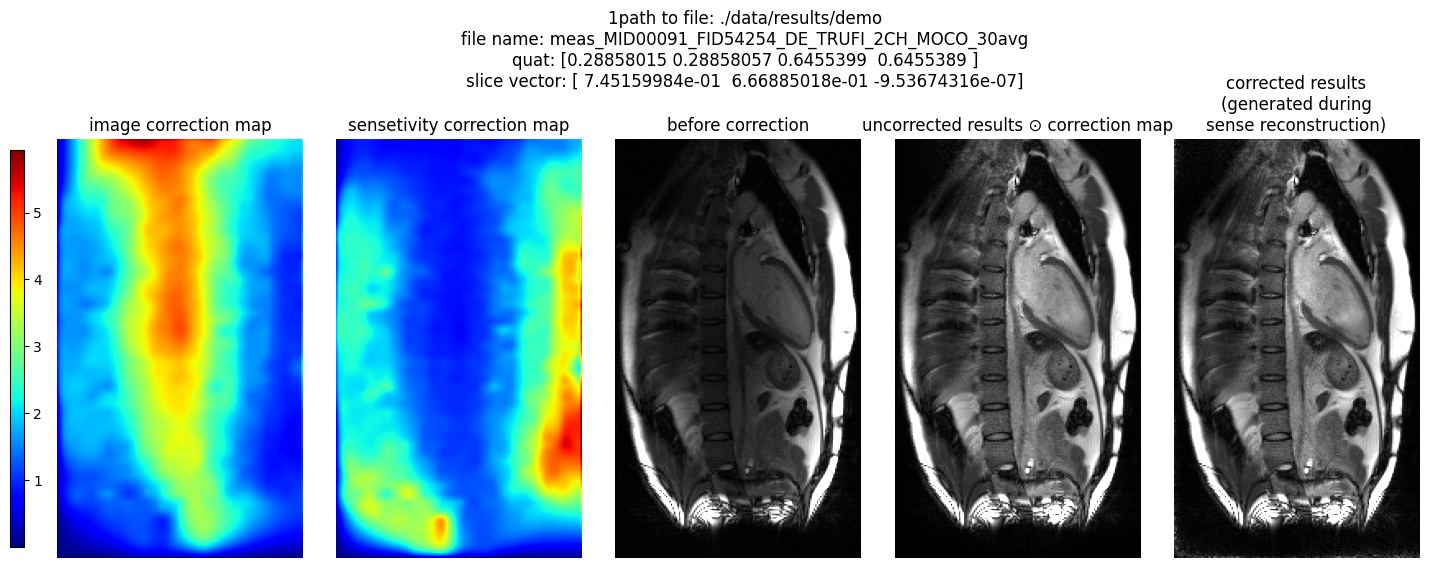

In [10]:
sli_idx = 0 #changing this number will show different slices
input_subfolders = ['demo'] #set this to None, if you want to go through all the subfolders inside input_folder
output_folder = "results"
displaying_results(base_dir=base_dir, input_folder=input_folder,
                   output_folder=output_folder, folder_names=input_subfolders, sli_idx=sli_idx,
                   fig_h=9, show_both=True) #set show_both = True to display both results